<a href="https://colab.research.google.com/github/DiegoBores/Clickbait-detector/blob/main/Detector_de_Clickbait.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Instalamos la biblioteca de TensorFlow, y los modelos de la versión 2.7.0, e importamos las librerias que vamos a utilizar

In [ ]:
!pip install tensorflow

In [ ]:
!pip install -q tf-models-official==2.7.0

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
from official.nlp import optimization #for  AdamW optimizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score


# Dataset y análisis descriptivo

En primer lugar obtenemos el dataset desde los enlaces correspondientes. Se trata de dos ficheros .csv que se encuentran en :


*   Conjunto de entrenamiento: https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_train.csv

*   Conjunto de test: https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_test.csv




In [ ]:
#Obtenemos las URL y los path relativos correspondientes a los dataset de entrenamiento y de test
TRAIN_DATA_URL = "https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_train.csv"#URL del conjunto de entrenamiento
TEST_DATA_URL = "https://ml-coding-test.s3.eu-west-1.amazonaws.com/webis_test.csv"#URL del conjunto de test

#Descargamos los datasets
train_file_path = tf.keras.utils.get_file("webis_train.csv", TRAIN_DATA_URL,
                                          cache_dir='.', cache_subdir='datasets')
test_file_path = tf.keras.utils.get_file('webis_test.csv', TEST_DATA_URL,
                                         cache_dir='.', cache_subdir='datasets')

90128384/90117240 [==============================] - 4s 0us/step


In [ ]:
#Leemos los csv y los almacenamos en sendos dataframes de pandas
train_df = pd.read_csv(train_file_path) 
test_df = pd.read_csv(test_file_path)



> # Análisis del contenido 


El dataset que vamos a utilizar cuenta con varias columnas correspondientes a la información de cada tweet (target), incluyendo contenido multimedia e información de los enlaces incluidos en el post, y varias columnas correspondientes a los datos relativos a la clasificaion (truth). De acuerdo con https://webis.de/data/webis-clickbait-17.html , la clasificación se ha realizado mediante una escala de 4 valores (0: no es clikbait, 0.33: ligeramente clickbait, 0.66: considerablemente clickbait, 1 altamente clickbait), por cinco observadores. Por lo tanto, se decide que es clickbait si la media de los valores indicados por los observadores es mayor que 0.5.





In [ ]:
#Podemos ver una muestra del dataset de entrenamiento
train_df.sample(5)

,Unnamed: 0,postMedia,postText,id,targetCaptions,targetParagraphs,targetTitle,postTimestamp,targetKeywords,targetDescription,truthJudgments,truthMean,truthClass,truthMedian,truthMode
3875,3875,[],Mike Rowe to flag-burning students: If you hat...,804717925584306176,"['Johnson', 'Johnson']",['LOOK: Jesus Statue Is All That\'s Left of TN...,Mike Rowe to Flag-Burning Students: If You Hat...,Fri Dec 02 16:04:39 +0000 2016,NaN,Dirty Jobs host Mike Rowe took to Facebook to ...,"[0.0, 0.0, 0.0, 0.0, 0.6666666666000001]",0.133333,no-clickbait,0.000000,0.000000
4004,4004,[],Deviate: The Science of Seeing Differently – w...,855815487099416576,['Lotto thinks our perceptions terminate at th...,['A neuroscientist argues that all experience ...,Deviate: The Science of Seeing Differently by ...,Sat Apr 22 16:08:07 +0000 2017,"Science and nature,Philosophy,Books,Culture,Ne...",A neuroscientist argues that all experience oc...,"[0.6666666666000001, 0.0, 0.33333333330000003,...",0.333333,no-clickbait,0.333333,0.333333
18509,18509,[],Can cricket be saved from itself? How the ICC ...,832186276895944704,"['Cricket', 'Cricket', 'MS Dhoni of India', 'E...","['Nestled amid skyscrapers in the desert, an u...",Can cricket be saved from itself? How the ICC ...,Thu Feb 16 11:14:04 +0000 2017,"International Cricket Council,Australia cricke...",With skill and appetite growing outside Test-p...,"[0.6666666666000001, 0.33333333330000003, 0.33...",0.400000,no-clickbait,0.333333,0.333333
7893,7893,[],Doctor accused of mutilating genitals of young...,856470650856382464,"['FBI agents leave a clinic in Livonia, Mich.,...",['The attorney for a Detroit-area doctor accus...,Doctor accused of mutilating genitals of young...,Mon Apr 24 11:31:30 +0000 2017,"genital mutilation, Michigan",The physician's attorney said the procedure wa...,"[0.0, 0.0, 0.0, 0.33333333330000003, 0.3333333...",0.133333,no-clickbait,0.000000,0.000000
11371,11371,[],Nigeria's starving children who fled Boko Haram,814169646857330688,"[""Nigeria's starving children"", 'Hundreds of t...",['Nigeria has been hit by the biggest humanita...,Nigeria's starving children who fled Boko Haram,Wed Dec 28 18:02:25 +0000 2016,NaN,Children could die of starvation in Nigeria un...,"[0.33333333330000003, 0.6666666666000001, 0.66...",0.600000,clickbait,0.666667,0.666667


Comprobamos que no haya valores null en los campos que nos interesan

In [ ]:
train_df.isnull().any()

Unnamed: 0           False
postMedia            False
postText              True
id                   False
targetCaptions       False
targetParagraphs     False
targetTitle          False
postTimestamp        False
targetKeywords        True
targetDescription     True
truthJudgments       False
truthMean            False
truthClass           False
truthMedian          False
truthMode            False
dtype: bool

In [ ]:
test_df.isnull().any()

Unnamed: 0           False
id                   False
postMedia            False
targetCaptions       False
postText              True
postTimestamp        False
targetTitle          False
targetDescription     True
targetKeywords        True
targetParagraphs     False
truthJudgments       False
truthClass           False
truthMedian          False
truthMode            False
truthMean            False
dtype: bool

Puesto que la columna de texto que nos interesa tiene valores Null, debemos eliminarlos para que no nos de problemas a la hora de entrenar el modelo



In [ ]:
train_df = train_df.dropna(how='any',subset=['postText', 'truthClass'], axis=0)
test_df = test_df.dropna(how='any',subset=['postText', 'truthClass'], axis=0)

In [ ]:
#Cambiamos los valores de 'truthClass' a valores 1 o 0 en funcion de si es un clickbait o no
#En el conjunto de entrenamiento
train_df['truthClass'] = train_df['truthClass'].apply(lambda x: 1 if x=='clickbait' else 0 )
train_df.rename(columns={'truthClass':'target'}, inplace=True)
#En el conjunto de test
test_df['truthClass'] = test_df['truthClass'].apply(lambda x: 1 if x=='clickbait' else 0 )
test_df.rename(columns={'truthClass':'target'}, inplace=True)

In [ ]:
#contamos  cuantos ejemplos del dataset de entrenamiento contienen un clickbait y cuantos no
train_df['target'].value_counts()

0    14768
1     4716
Name: target, dtype: int64



> # Análisis de las muestras


Un 33% de los valores son clickbait. Implica un desbalanceo entre las clases que podría conducir a un alto sesgo durante el entrenamiento del modelo. Para evitar esto vamos a intentar balancear los datos, eliminando elementos que contengan 'no-clickbait' hasta que igualen a los de 'clikbait'. 
Además, por motivos de limitaciones computacionales y de tiempo, la reducción del conjunto de entrenamiento agiliza las pruebas, si bien podría conducir a un problema de alta varianza por falta de datos. Cabe destacar que se realizó una prueba con el primer algoritmo, y pese a que las métricas accuracy y presicion eran relativamente buenas, la métrica de recall dejaba bastante que desear. A continuación podemos ver los resultados de la última de 6 iteraciones:

Esto nos indica que el modelo está prediciendo con cierto sesgo hacia 'no clickbait'. 

In [ ]:
df_clickbait = train_df[train_df['target']==1]
df_noclickbait = train_df[train_df['target']==0]

df_noclickbait_downsampled=df_noclickbait.sample(df_clickbait.shape[0])

train_df = pd.concat([df_noclickbait_downsampled, df_clickbait])
# train_df=train_df.sample(8000)#Reducimos el tamaño del dataset por motivos computacionales
del df_clickbait, df_noclickbait, df_noclickbait_downsampled

In [ ]:
train_df['target'].value_counts()

0    4716
1    4716
Name: target, dtype: int64

Dividimos el dataset en train y validation, en una relacion 80/20, para poder representar las curvas de aprendizaje y comparar como se comporta el modelo en el entrenamiento y cómo es capaza de generalizar a nuevos ejemplos, y su evolución con el número de iteraciones.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_df['postText'],train_df['target'], train_size=0.8)
del train_df

Vamos a extraer del conjunto de test las columnas que nos interesan, y en el mismo formato que los de entrenamiento:

In [ ]:
X_test = test_df['postText']
y_test = test_df['target']

del test_df

# Modelos a utilizar:

Utilizaremos tres modelos:


*   Un modelo BERT sencillo, llamado Small BERT
*   ELECTRA base
*   Un baseline sencillo para comparar los resultados obtenidos




> # Small BERT

Se trata de un modelo basado en BERT original, pero con menos bloques Transformer y/o más pequeños.

Utilizaremos el modelo Small BERT con configuración L12, H738, A12





In [ ]:
smallBERT_preprocess_handle = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
smallBERT_encoder_handle = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1', trainable=True)


 > > > # Modelo de preprocesado


Las entradas de texto deben ser transformadas a tokens numericoas y agrupados en tensores antes de ser entradas de BERT. TensorFlow Hub facilita un modelo de preprocesamiento para cada modelo BERT por lo que no es necesario correr codigo de Python especifico fura del modelo de TensorFlow para preprocesar el texto.

Del preprocesado hay tres salidas principales, que serán las utilizadas por el modelo BERT: ,  e 


*  input_words_id: simplemente el identificador de frase
*  input_mask: para indicar al modelo BERT qué tokens corresponden a padding.
*  input_type_ids: los tokens en que se ha transformado el texto de entrada






> > > # Modelo BERT

Los modelos BERT devuelven un map con 3 keys importantes: pooled_output, sequence_output y encoder_outputs:


*   pooled_output representa cada frase de entrada como un conjunto. Las dimensiones son [batch_size, H].


*   sequence_output representa cada token de entrada en el contexto. Las dimensiones son [batch_size, seq_length, H].


*   encoder_outputs son las activaciones intermedias de los L bloques Transformer.

Para el fine-tunning se utiliza el array pooled_output

> > > # Definicion del modelo

El modelo utilizado es sencillo:  el preprocesado, el modelo Small BERT, una capa Dropout y una capa Dense.

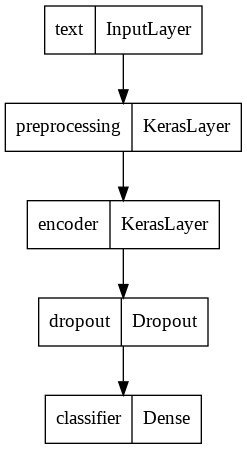


In [ ]:
#Crearemos una función que construya el modelo a apartir de las url del modulo de preprocesado y del modulo BERT empleado
def build_classifier_model(preprocess_handle, encoder_handle):
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preprocess_handle, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(encoder_handle, trainable = True, name='encoder')
  outputs = encoder(encoder_inputs)
  net=outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)


Vamos a echar un vistazo al esquema del modelo



In [ ]:
smallBERT_classifier_model = build_classifier_model(smallBERT_preprocess_handle , smallBERT_encoder_handle)
del smallBERT_preprocess_handle, smallBERT_encoder_handle

In [ ]:
tf.keras.utils.plot_model(smallBERT_classifier_model)

In [ ]:
smallBERT_classifier_model.summary()

> > > # Función de pérdidas, optimizador y metricas

Dado que se trata de un problema de clasificacion binaria, y la salida del modelo es una probabilidad (es una capa con una única unidad), utilizaremos la funcion de costes losses.BinaryCrossentropy:



In [ ]:
loss = tf.keras.losses.BinaryCrossentropy()

Las métricas que utilizaremos son :

*   Accuracy: mide la frecuencia con la que la predicción coincide con el valor real. Sin embargo, cuando las clases estan desbalanceads esta métrica puede llevar a error
*   Precission: del conjunto de ejemplos clasificados como 'clickbait', indica cuántos realmente lo son.
*   Recall: del conjunto real de ejemplos clasificados 'clickbait', nos indica cuántos fueron detectados. 

In [ ]:
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy'),
           tf.keras.metrics.Precision(name='precission'),
           tf.keras.metrics.Recall(name='recall')
]

Para el fine-tunning utilizaremos el mismo optimizador Adamw, que minimiza la perdida de la prediccion y emplea regularización mediante disminucion de pesos (no emplea momentos), que se conoce como AdamW.

Para la tasa de aprendizaje (init_lr) emplearemos el mismo esquema que en el pre-entrenamiento de BERT: disminucion linear de una tasa inicial, prefijada con una fase de calentamiento linear sobre el 10% de los pasos de entrenamiento(num_warmup_steps). De acuerdo con el paper de BERT, la tasa de aprendizaje inicial debe ser más pequeña para el fine-tunning( mejor de 5e-5, 3e-5, 2e-5)

In [ ]:
epochs = 10 #numero de epochs inicialmente 1
batch_size=32 #tamaño de batch 
steps_per_epoch = len(X_train)/batch_size #Definimos el número de pasos 
num_train_steps = steps_per_epoch * epochs #Numero de pasos de entrenamiento
num_warmup_steps = int(0.1*num_train_steps) #Numero de pasos de calentamiento

#Tasa de aprendizaje inicial
init_lr = 5e-5

optimizer = optimization.create_optimizer(init_lr = init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

> > > # Compilando el modelo y fine-tunning

A continuación, compilamos el modelo definido anteriormente. 



In [ ]:
smallBERT_classifier_model.compile(optimizer= optimizer,
                                   loss=loss,
                                   metrics = METRICS)

Y realizamos el fine-tunning. Por limitaciones computacionales y de tiempo, reduciremos el numero de epochs a 10, si bien este numero debería ser bastante mayor. 